In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Paramètres de la pipeline

In [33]:
code_departement = "093"
logs_level = "WARNING"

# Imports & setup

In [34]:
import geopandas as gpd
!pip install thefuzz py7zr
import sys
import os
sys.path.append(os.path.abspath("..")) 
from potentiel_solaire.attach_buildings_to_schools import attach_buildings_to_schools
from potentiel_solaire.constants import CRS, ALGORITHME_FOLDER, DATA_FOLDER
from potentiel_solaire.sources.bd_topo import extract_bd_topo, get_topo_zones_of_interest, \
    get_topo_buildings_of_interest
from potentiel_solaire.sources.bd_pci import extract_bd_pci
from potentiel_solaire.sources.bd_solar_irradiation import extract_bd_irradiation
from potentiel_solaire.sources.schools_establishments import extract_schools_establishments, \
    get_schools_establishments_of_interest
from potentiel_solaire.features.solar_potential import calculate_solar_potential
from potentiel_solaire.aggregate import aggregate_solar_potential_by
from potentiel_solaire.logger import get_logger

logger = get_logger()
logger.setLevel(logs_level)


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Extraction des données sources

### Etablissements scolaires

In [35]:
schools_establishments_path = extract_schools_establishments()
print(f"Annuaire des établissements scolaires extrait ici: {schools_establishments_path}")

Annuaire des établissements scolaires extrait ici: /Users/sarahlenet/Desktop/potentiel_solaire/13_potentiel_solaire/algorithme/data/fr-en-annuaire-education.geojson


### BD TOPO

In [36]:
bd_topo_path = extract_bd_topo(code_departement=code_departement)
print(f"BD TOPO extraite ici: {bd_topo_path}")

BD TOPO extraite ici: /Users/sarahlenet/Desktop/potentiel_solaire/13_potentiel_solaire/algorithme/data/BDTOPO_3-4_TOUSTHEMES_GPKG_LAMB93_D093_2024-12-15/BDTOPO/1_DONNEES_LIVRAISON_2024-12-00134/BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15/BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15.gpkg


### BD PCI

In [37]:
bd_pci_path = extract_bd_pci(code_departement=code_departement)
print(f"BD PCI extraite ici: {bd_pci_path}")

BD PCI extraite ici: /Users/sarahlenet/Desktop/potentiel_solaire/13_potentiel_solaire/algorithme/data/PARCELLAIRE-EXPRESS_1-1__SHP_LAMB93_D093_2025-01-01/PARCELLAIRE-EXPRESS/1_DONNEES_LIVRAISON_2025-02-00010/PEPCI_1-1_SHP_LAMB93_D093/BATIMENT.SHP


### BD IRRADIATION

In [38]:
bd_irradiation_path = extract_bd_irradiation()
print(f"BD irradiation extraite ici: {bd_irradiation_path}")

BD irradiation extraite ici: /Users/sarahlenet/Desktop/potentiel_solaire/13_potentiel_solaire/algorithme/data/ENR_1-0_IRR-SOL_TIFF_WGS84G_FXX_2023-10-01/1_DONNEES_LIVRAISON/GlobalHorizontalIrradiation.tif


# Filtre des données sur le périmètre du calcul

### Etablissements scolaires


In [39]:
schools_establishments = get_schools_establishments_of_interest(
    schools_filepath=schools_establishments_path,
    code_departement=code_departement,
    types_etablissements=['Ecole', 'Lycée', 'Collège'],
    statut_public_prive="Public",
    etat="OUVERT",
    crs=CRS
)
nb_schools = schools_establishments.shape[0]
print(f"Nb d'établissements scolaires: {nb_schools}")

Nb d'établissements scolaires: 1130


### Zone d'intérêt géographique

In [40]:
codes_commune = schools_establishments["code_commune"].unique()
communes = gpd.read_file(bd_topo_path, layer="commune").to_crs(CRS)
communes = communes[communes.code_insee.isin(codes_commune)]
geom_of_interest = communes.dissolve()[["geometry"]]

### Zones d'éducations

In [41]:
educational_zones = get_topo_zones_of_interest(
    bd_topo_path=bd_topo_path,
    geom_of_interest=geom_of_interest,
    categories=["Science et enseignement"],
    natures=['Collège', 'Lycée', 'Enseignement primaire'],
    crs=CRS
)
nb_educational_zones = educational_zones.shape[0]
print("Nb de zones d'éducations: ", nb_educational_zones)

/opt/anaconda3/lib/python3.11/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying' not supported
  return ogr_read_info(
/opt/anaconda3/lib/python3.11/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(256)' not supported
  return ogr_read_info(
/opt/anaconda3/lib/python3.11/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(30)' not supported
  return ogr_read_info(
/opt/anaconda3/lib/python3.11/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'timestamp with time zone' not supported
  return ogr_read_info(
/opt/anaconda3/lib/python3.11/site-packages/geopandas/io/file.py:497: UserWarning: More than one layer found in 'BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15.gpkg': 'troncon_de_route' (default), 'route_numerotee_ou_nommee', 'itineraire_autre', 'troncon_de_voie_ferree', 'equipement_de_transport', 'piste_d_aerodrome', 'aerodrome', 'point_de_repere', 'non_communication', 'point_du_re

Nb de zones d'éducations:  1088


### Bâtiments

In [42]:
# TODO : ajout des batiments manquants avec la BD PCI
buildings = get_topo_buildings_of_interest(
    bd_topo_path=bd_topo_path,
    geom_of_interest=geom_of_interest,
    crs=CRS
)
nb_buildings = buildings.shape[0]
print("Nb de batiments: ", nb_buildings)

/opt/anaconda3/lib/python3.11/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying' not supported
  return ogr_read_info(
/opt/anaconda3/lib/python3.11/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(256)' not supported
  return ogr_read_info(
/opt/anaconda3/lib/python3.11/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(30)' not supported
  return ogr_read_info(
/opt/anaconda3/lib/python3.11/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'timestamp with time zone' not supported
  return ogr_read_info(
/opt/anaconda3/lib/python3.11/site-packages/geopandas/io/file.py:497: UserWarning: More than one layer found in 'BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15.gpkg': 'troncon_de_route' (default), 'route_numerotee_ou_nommee', 'itineraire_autre', 'troncon_de_voie_ferree', 'equipement_de_transport', 'piste_d_aerodrome', 'aerodrome', 'point_de_repere', 'non_communication', 'point_du_re

Nb de batiments:  351577


# Détermination des bâtiments scolaires

In [43]:
schools_buildings = attach_buildings_to_schools(
        schools_establishments=schools_establishments,
        educational_zones=educational_zones,
        buildings=buildings
)

/opt/anaconda3/lib/python3.11/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [24]:
schools_buildings

,cleabs_bat,construction_legere,hauteur,geometry,index_zone,cleabs_zone,categorie,nature,toponyme,identifiant_de_l_etablissement
4,BATIMENT0000000229474428,False,24.7,"MULTIPOLYGON Z (((2.3241 48.90492 44.5, 2.3240...",409,SURFACTI0000000002555886,Science et enseignement,Enseignement primaire,École Maternelle Victor Hugo,0930409P
237,BATIMENT0000000243403398,False,7.2,"MULTIPOLYGON Z (((2.36008 48.9081 44.2, 2.3601...",418,SURFACTI0000000246200139,Science et enseignement,Enseignement primaire,École Élémentaire Louis Antoine Saint-Just,0931478B
238,BATIMENT0000000243403396,False,6.8,"MULTIPOLYGON Z (((2.36022 48.90797 43.8, 2.359...",418,SURFACTI0000000246200139,Science et enseignement,Enseignement primaire,École Élémentaire Louis Antoine Saint-Just,0931478B
245,BATIMENT0000000243403399,True,NaN,"MULTIPOLYGON Z (((2.36046 48.90831 -1000, 2.36...",418,SURFACTI0000000246200139,Science et enseignement,Enseignement primaire,École Élémentaire Louis Antoine Saint-Just,0931478B
253,BATIMENT0000000243403625,False,NaN,"MULTIPOLYGON Z (((2.36118 48.908 -1000, 2.3612...",418,SURFACTI0000000246200139,Science et enseignement,Enseignement primaire,École Élémentaire Louis Antoine Saint-Just,0931478B
...,...,...,...,...,...,...,...,...,...,...
348076,BATIMENT0000000246439599,True,NaN,"MULTIPOLYGON Z (((2.58408 48.94175 -1000, 2.58...",306,SURFACTI0000000002555563,Science et enseignement,Collège,Collège Romain Rolland,0931191P
348077,BATIMENT0000000246439600,True,NaN,"MULTIPOLYGON Z (((2.58405 48.9419 -1000, 2.584...",306,SURFACTI0000000002555563,Science et enseignement,Collège,Collège Romain Rolland,0931191P
348090,BATIMENT0000000246440832,False,NaN,"MULTIPOLYGON Z (((2.58372 48.94178 -1000, 2.58...",306,SURFACTI0000000002555563,Science et enseignement,Collège,Collège Romain Rolland,0931191P
348100,BATIMENT0000002244515389,False,NaN,"MULTIPOLYGON Z (((2.58291 48.94149 -1000, 2.58...",306,SURFACTI0000000002555563,Science et enseignement,Collège,Collège Romain Rolland,0931191P


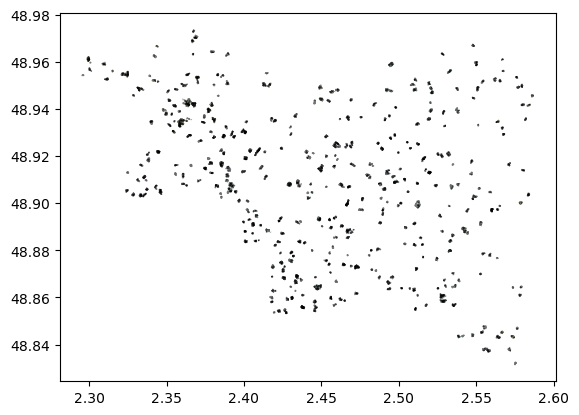

In [15]:
import matplotlib.pyplot as plt
import geopandas as gdp
gdf = schools_buildings.copy()
gdf.plot(edgecolor = 'black', cmap ='viridis', alpha=0.5)
plt.show()

In [16]:
gdf.copy().explode(index_parts=False)[gdf.explode(index_parts=False).loc[:,['cleabs_bat']].duplicated()]

,cleabs_bat,construction_legere,hauteur,index_zone,cleabs_zone,categorie,nature,toponyme,identifiant_de_l_etablissement,geometry
3646,BATIMENT0000000002670922,False,14.1,328,SURFACTI0000000002555819,Science et enseignement,Enseignement primaire,École Maternelle Jean Jaurès,0930470F,"POLYGON Z ((2.33552 48.91138 47.9, 2.33604 48...."
7683,BATIMENT0000000245586773,False,15.6,74,SURFACTI0000000002555703,Science et enseignement,Enseignement primaire,École Élémentaire Paul Langevin,0930566K,"POLYGON Z ((2.37993 48.92809 53.6, 2.37987 48...."
8057,BATIMENT0000000243405487,False,6.7,347,SURFACTI0000000002555708,Science et enseignement,Enseignement primaire,École Maternelle Bel-Air,0930438W,"POLYGON Z ((2.3655 48.92854 37.8, 2.3656 48.92..."
10109,BATIMENT0000000246488966,False,11.4,416,SURFACTI0000000002555879,Science et enseignement,Enseignement primaire,École Maternelle Jules Michelet,0930475L,"POLYGON Z ((2.34546 48.90476 49, 2.34543 48.90..."
10184,BATIMENT0000000246489005,False,4.1,416,SURFACTI0000000002555879,Science et enseignement,Enseignement primaire,École Maternelle Jules Michelet,0930475L,"POLYGON Z ((2.34598 48.9046 42.6, 2.34601 48.9..."
13673,BATIMENT0000000246178997,False,16.6,395,SURFACTI0000000002556134,Science et enseignement,Collège,Collège Marcelin Berthelot,0931210K,"POLYGON Z ((2.43693 48.85583 79, 2.43707 48.85..."
13675,BATIMENT0000000246178999,False,4.4,395,SURFACTI0000000002556134,Science et enseignement,Collège,Collège Marcelin Berthelot,0931210K,"POLYGON Z ((2.4376 48.85561 66.8, 2.43734 48.8..."
13684,BATIMENT0000000246178998,True,NaN,395,SURFACTI0000000002556134,Science et enseignement,Collège,Collège Marcelin Berthelot,0931210K,"POLYGON Z ((2.43741 48.85579 -1000, 2.43753 48..."
13690,BATIMENT0000000246179032,True,NaN,395,SURFACTI0000000002556134,Science et enseignement,Collège,Collège Marcelin Berthelot,0931210K,"POLYGON Z ((2.43728 48.8561 -1000, 2.43733 48...."
13975,BATIMENT0000000246179000,False,14.3,395,SURFACTI0000000002556134,Science et enseignement,Collège,Collège Marcelin Berthelot,0931210K,"POLYGON Z ((2.438 48.856 76.7, 2.43801 48.8560..."


In [27]:
import geopandas as gpd
import pandas as pd

# Load the GeoJSON file
gdf = schools_buildings

# Ensure the data is in EPSG:4326 (WGS84)
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)

# Convert to a projected CRS (use an appropriate UTM zone or EPSG:2154 for France)
gdf_m = gdf.to_crs(epsg=2154)

def extract_polygon_info(geometry, crs_target=4326):
    """
    Extracts areas and centroids for each polygon within a MultiPolygon.
    Returns two lists: one for areas and one for centroid coordinates.
    """
    surfaces = []
    coordinates = []
    
    if geometry.geom_type == "MultiPolygon":
        polygons = list(geometry.geoms)  # Extract individual polygons
    else:
        polygons = [geometry]  # Treat as a single polygon
    
    for poly in polygons:
        surfaces.append(poly.area)  # Compute area in square meters
        
        # Compute centroid in the projected CRS
        centroid = poly.centroid

        # Convert centroid to EPSG:4326 (latitude/longitude)
        centroid_transformed = gpd.GeoSeries(centroid, crs=gdf_m.crs).to_crs(epsg=crs_target).geometry[0]

        coordinates.append((centroid_transformed.y, centroid_transformed.x))  # Store as (lat, lon)

    return surfaces, coordinates

# Apply the function to extract surfaces and coordinates
gdf_m[["surfaces", "coordinates"]] = gdf_m.geometry.apply(lambda geom: pd.Series(extract_polygon_info(geom)))

# Convert back to EPSG:4326 to maintain original coordinates
gdf = gdf_m.to_crs(epsg=4326)

# Save the results to a new GeoJSON or CSV
gdf.to_file("output.geojson", driver="GeoJSON")
gdf = gdf[~gdf['hauteur'].isna()]
gdf[["surfaces", "coordinates", "hauteur"]].to_csv("output.csv", index=False)

# Print final result
print(gdf[["surfaces", "coordinates", "hauteur"]])


                    surfaces                                 coordinates  \
4        [390.4899999601731]    [(48.90478889839129, 2.324038982442142)]   
237     [2168.7349999616486]  [(48.908248667413204, 2.3605689865764745)]   
238      [312.9350000213983]   [(48.90802948085998, 2.3600530802722632)]   
254      [578.4199999972143]   [(48.90816669545216, 2.3614541903823887)]   
259     [112.95999998859246]  [(48.908216909708294, 2.3607690337429705)]   
...                      ...                                         ...   
346078   [567.4249999633001]    [(48.94999899818562, 2.579287602709854)]   
347017   [1583.334999886898]   [(48.94547518340608, 2.5861604076157887)]   
347035   [1893.940000016035]   [(48.945853662897946, 2.586146317910487)]   
348064  [19.914999995214167]  [(48.941533633863294, 2.5828684255098797)]   
348181  [371.25500000326895]   [(48.94190543662272, 2.5848208304523097)]   

        hauteur  
4          24.7  
237         7.2  
238         6.8  
254         7.0

In [44]:
import geopandas as gpd
import pandas as pd

# Load the GeoJSON file
gdf = schools_buildings
gdf = gdf.explode(index_parts=False)


# Ensure the data is in EPSG:4326 (WGS84)
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)

# Convert to a projected CRS (use an appropriate UTM zone or EPSG:2154 for France)
gdf_m = gdf.to_crs(epsg=2154)

def extract_polygon_info(geometry, crs_target=4326):
    """
    Extracts areas and centroids for each polygon within a MultiPolygon.
    Returns two lists: one for areas and one for centroid coordinates.
    """
    surfaces = []
    lat = []
    long = []
    
    if geometry.geom_type == "MultiPolygon":
        polygons = list(geometry.geoms)  # Extract individual polygons
    else:
        polygons = [geometry]  # Treat as a single polygon
    
    for poly in polygons:
        surfaces.append(poly.area)  # Compute area in square meters
        
        # Compute centroid in the projected CRS
        centroid = poly.centroid

        # Convert centroid to EPSG:4326 (latitude/longitude)
        centroid_transformed = gpd.GeoSeries(centroid, crs=gdf_m.crs).to_crs(epsg=crs_target).geometry[0]

        lat.append(centroid_transformed.y)  # Store lat
        long.append(centroid_transformed.x) # Store lon

    return surfaces, lat, long

# Apply the function to extract surfaces and coordinates

gdf_m[["surfaces", "lat", "long"]] = gdf_m.geometry.apply(lambda geom: pd.Series(extract_polygon_info(geom)))

for column in ["surfaces", "lat", "long"]: #TODO change place of this 
    gdf_m[column] = gdf_m[column].apply(lambda x: x[0])

# Convert back to EPSG:4326 to maintain original coordinates
gdf = gdf_m.to_crs(epsg=4326)

# Save the results to a new GeoJSON or CSV
gdf.to_file("output.geojson", driver="GeoJSON")
gdf = gdf[~gdf['hauteur'].isna()] #TODO replace hauteur with mean or median values
gdf[["cleabs_bat","surfaces", "lat", "long", "hauteur"]].to_csv("output.csv", index=False)

# Print final result
print(gdf[["surfaces", "lat", "long", "hauteur"]])



        surfaces        lat      long  hauteur
4        390.490  48.904789  2.324039     24.7
237     2168.735  48.908249  2.360569      7.2
238      312.935  48.908029  2.360053      6.8
254      578.420  48.908167  2.361454      7.0
259      112.960  48.908217  2.360769      6.5
...          ...        ...       ...      ...
346078   567.425  48.949999  2.579288      6.4
347017  1583.335  48.945475  2.586160      6.4
347035  1893.940  48.945854  2.586146      9.7
348064    19.915  48.941534  2.582868      3.1
348181   371.255  48.941905  2.584821      5.0

[3077 rows x 4 columns]


In [ ]:
import os
print(os.path.exists("../data/potentiel-solaire.geojson"))

True


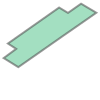

In [43]:
gdf.explode(index_parts=False)[gdf.explode(index_parts=False)['cleabs_bat'] == 'BATIMENT0000000246489005']['geometry'].iloc[0]

# Calcul des attributs utiles pour le potentiel solaire

In [17]:
# TODO: v0 seulement à ce stade
solar_potential_of_schools_buildings = calculate_solar_potential(
    schools_buildings=schools_buildings,
    bd_irradiation_path=bd_irradiation_path
)

# Dump des donnees pour analyses

In [18]:
solar_potential_of_schools_buildings["zone_autour_du_batiment"] = solar_potential_of_schools_buildings["zone_autour_du_batiment"].to_wkt()

layers = ["schools_establishments", "educational_zones", "schools_buildings", "solar_potential_of_schools_buildings"]
gdfs = [schools_establishments, educational_zones, schools_buildings, solar_potential_of_schools_buildings]

for layer, gdf in zip(layers, gdfs):
    output_gpkg = DATA_FOLDER / f"{code_departement}_pipeline_results.gpkg"
    gdf.to_file(output_gpkg, layer=layer, driver="GPKG")

# Checks sur la qualité des données & calculs

In [19]:
nb_schools_with_buildings = len(schools_buildings.identifiant_de_l_etablissement.unique())
print("Nb d'établissements scolaires avec des batiments: {} ({}%)".format(
    nb_schools_with_buildings,
    round(100 * nb_schools_with_buildings / nb_schools)
))

Nb d'établissements scolaires avec des batiments: 445 (39%)


# Aggrégations

### Par établissement scolaire

In [20]:
results_by_school = aggregate_solar_potential_by(
    schools_establishments=schools_establishments,
    solar_potential_of_schools_buildings=solar_potential_of_schools_buildings,
    group_by = [
        "identifiant_de_l_etablissement",
        "nom_etablissement",
        "type_etablissement",
        "libelle_nature",
        "code_commune",
        "nom_commune",
        "code_departement",
        "libelle_departement",
        "code_region",
        "libelle_region",
    ]
)

### Par commune

In [21]:
results_by_commune = aggregate_solar_potential_by(
    schools_establishments=schools_establishments,
    solar_potential_of_schools_buildings=solar_potential_of_schools_buildings,
    group_by = [
        "code_commune",
        "nom_commune",
        "code_departement",
        "libelle_departement",
        "code_region",
        "libelle_region",
    ]
)
# TODO : la geometrie de la commune est fausse

### Par département

In [22]:
results_by_departement = aggregate_solar_potential_by(
    schools_establishments=schools_establishments,
    solar_potential_of_schools_buildings=solar_potential_of_schools_buildings,
    group_by = [
        "code_departement",
        "libelle_departement",
        "code_region",
        "libelle_region",
    ]
)
# TODO : la geometrie du departement est fausse

### Par région

In [ ]:
# TODO : demande de se connecter au bucket avec les resultats existants pour aggreger 
# TODO : ou de faire le calcul pour tous les departements d une region

# Sauvegarde des fichiers

In [23]:
output_folder = ALGORITHME_FOLDER.parent / "results" / f"D{code_departement}"
output_folder.mkdir(exist_ok=True, parents=True)

# TODO : a voir cote front sil faut changer le format de mise a disposition
results_by_school.to_file(output_folder / f"D{code_departement}_ecoles.geojson", driver="GeoJSON")
results_by_commune.to_file(output_folder / f"D{code_departement}_communes.geojson", driver="GeoJSON")
results_by_departement.to_file(output_folder / f"D{code_departement}_departement.geojson", driver="GeoJSON")